In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import time
import pickle
import torch, torchvision
import torch.nn as nn
import torch.nn.functional as F
import copy
from abc import ABC, abstractmethod

from cubic_subproblem_solver import *

# Helper functions

In [2]:
def get_principal_vecs(X, new_dim):
    assert new_dim <= X.shape[1]
    sigma, V = torch.linalg.eigh(X.T @ X)
    princ_vecs = V[:,-new_dim:]
    return princ_vecs


def load_and_transform_mnist(new_dim):
    mnist_trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=None)
    mnist_testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=None)
    
    X_train = mnist_trainset.data.reshape(-1,28*28) / 255.
    y_train = mnist_trainset.targets
    X_test = mnist_testset.data.reshape(-1,28*28) / 255.
    y_test = mnist_testset.targets
    
    princ_vecs = get_principal_vecs(X_train, new_dim)
    X_train = X_train @ princ_vecs
    X_test = X_test @ princ_vecs
    
    mnist_dataset = {
        "train_data": X_train,
        "train_targets": y_train,
        "test_data": X_test,
        "test_targets": y_test
    }
    
    return mnist_dataset


def transform_labels_to_binary(labels):
    return torch.tensor(list(map(lambda x: 0 if x<5 else 1, labels)))


class LogisticNet(nn.Module):
    
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.linear = nn.Linear(in_dim, out_dim)
    
    def forward(self, x):
        return self.linear(x)


class MLP(nn.Module):
    
    def __init__(self, dims, activation):
        super().__init__()
        assert len(dims) >= 2
        self.activation = activation
        self.n_layers = len(dims) - 1
        self.layers = nn.ModuleList()
        for i in range(self.n_layers):
            self.layers.append(nn.Linear(dims[i], dims[i+1]))
    
    def forward(self, x):
        for i in range(self.n_layers - 1):
            x = self.activation(self.layers[i](x))
        return self.layers[self.n_layers - 1](x)


def dict_lists_to_ndarrays(metrics):
    for key, value in metrics.items():
        metrics[key] = np.array(value)
    return metrics

# Abstract class Trainer

In [3]:
class Trainer(ABC):
    
    def __init__(self, model, dataset, criterion):
        
        self.model = model
        self.dataset = dataset
        self.criterion = criterion
        
        self.metrics = {
            "train_loss": [],
            "test_loss": [],
            "train_acc": [],
            "test_acc": [],
            "grad_norm": [],
            "time": [],
            "iter": []
        }
        
        # calculate metrics for initial model state
        self.update_metrics(0.0)
    
    def evaluate(self, X, y):
        with torch.no_grad():
            preds = self.model(X)
            loss = self.criterion(preds, y)
            preds = torch.argmax(preds, axis=1)
            acc = torch.mean((preds == y).float())
        return loss.item(), acc.item()
    
    def calculate_grad_norm(self, X, y):
        preds = self.model(X)
        loss = self.criterion(preds, y)
        self.model.zero_grad()
        loss.backward()
        grad_norm = math.sqrt(sum([p.grad.pow(2).sum() for p in self.model.parameters()]))
        return grad_norm
    
    def update_metrics(self, training_time, grad_norm=None):
        iteration = 0 if len(self.metrics["iter"]) == 0 else self.metrics["iter"][-1] + 1
        tr_loss, tr_acc = self.evaluate(self.dataset["train_data"], self.dataset["train_targets"])
        tst_loss, tst_acc = self.evaluate(self.dataset["test_data"], self.dataset["test_targets"])
        if grad_norm is None:
            grad_norm = self.calculate_grad_norm(self.dataset["train_data"], self.dataset["train_targets"])
        
        self.metrics["time"].append(training_time)
        self.metrics["iter"].append(iteration)
        self.metrics["grad_norm"].append(grad_norm)
        self.metrics["train_loss"].append(tr_loss)
        self.metrics["test_loss"].append(tst_loss)
        self.metrics["train_acc"].append(tr_acc)
        self.metrics["test_acc"].append(tst_acc)
    
    def afterprocess_metrics(self, max_time):
        assert len(self.metrics["time"]) > 0
        if self.metrics["time"][-1] > max_time:
            for key in self.metrics.keys():
                self.metrics[key].pop()
    
    @abstractmethod
    def print_training_stats(self):
        pass
    
    @abstractmethod
    def perform_training_loop(self, max_iters, max_time, print_every):
        pass
    
    def train(self, max_iters=None, max_time=None, print_every=None, eval_every=None):
        # every time we want to print metrics, it must be evaluated
        assert (print_every == None) or (print_every % eval_every == 0)
        assert max_iters != None or max_time != None
        if max_iters == None:
            max_iters = float('inf')
        if max_time == None:
            max_time = float('inf')
        
        if print_every != None:
            self.print_training_stats()
        
        self.perform_training_loop(max_iters, max_time, print_every, eval_every)

        self.afterprocess_metrics(max_time)
        return self.metrics.copy()

# GD with adaptive L as child class

In [4]:
class AdaptiveGDTrainer(Trainer):
    
    def __init__(self, model, dataset, criterion, L_0, L_min):
        
        super().__init__(model, dataset, criterion)
        self.L = L_0
        self.L_min = L_min
    
    def print_training_stats(self):
        print(f'{self.metrics["iter"][-1]: 6,d}: train loss = {self.metrics["train_loss"][-1]: .16f}, \
L = {self.L: .3f}, time = {self.metrics["time"][-1]: .2f} sec')
    
    def calculate_loss(self, another_model, X, y):
        with torch.no_grad():
            preds = another_model(X)
            loss = self.criterion(preds, y)
        return loss.item()
    
    def set_params(self, another_model, new_params):
        for p, d in zip(another_model.parameters(), new_params):
            p.data = d
    
    def perform_training_loop(self, max_iters, max_time, print_every, eval_every):
        start_time = time.perf_counter()
        total_time = self.metrics["time"][-1]
        i = 0
        while (i < max_iters and self.metrics["time"][-1] < max_time):
            
            outputs = self.model(self.dataset["train_data"])
            self.model.zero_grad()
            loss = self.criterion(outputs, self.dataset["train_targets"])
            loss.backward()
            grad_norm_squared = sum([p.grad.pow(2).sum().item() for p in self.model.parameters()])
            model_next = copy.deepcopy(self.model)
            new_params = [p.data - 1/self.L * p.grad for p in self.model.parameters()]
            self.set_params(model_next, new_params)
            while (self.calculate_loss(model_next, self.dataset["train_data"], self.dataset["train_targets"]) > 
                    loss.item() - 1/(2*self.L) * grad_norm_squared):
                self.L *= 2
                new_params = [p.data - 1/self.L * p.grad for p in self.model.parameters()]
                self.set_params(model_next, new_params)
            self.set_params(self.model, new_params)
            
            if (i+1) % eval_every == 0:
                total_time += time.perf_counter() - start_time
                self.update_metrics(total_time, math.sqrt(grad_norm_squared))
                if print_every != None and (i+1) % print_every == 0:
                    self.print_training_stats()
                start_time = time.perf_counter()
            self.L = max(self.L / 2, self.L_min)
            i += 1
        

# Cubic Newton with adaptive M as child class

In [5]:
class AdaptiveCubicNewtonTrainer(Trainer):
    
    def __init__(self, model, dataset, criterion, M_0, M_min):
        
        super().__init__(model, dataset, criterion)
        self.M = M_0
        self.M_min = M_min
    
    def print_training_stats(self):
        print(f'{self.metrics["iter"][-1]: 5,d}: train loss = {self.metrics["train_loss"][-1]: .16f}, \
M = {self.M: .3f}, time = {self.metrics["time"][-1]: .2f} sec')
    
    def calculate_loss(self, another_model, X, y):
        with torch.no_grad():
            preds = another_model(X)
            loss = self.criterion(preds, y)
        return loss.item()
    
    def calculate_gradient(self, X, y):
        preds = self.model(X)
        loss = self.criterion(preds, y)
        gradients = torch.autograd.grad(loss, self.model.parameters())
        grad = torch.cat([g.flatten() for g in gradients], dim=0)
        return grad
        
    def calculate_hessian(self, X, y):
        
        def calculate_loss(*params):
            assert len(params) % 2 == 0
            n_layers = len(params) // 2
            preds = X
            for i in range(n_layers):
                preds = preds @ params[2*i].T + params[2*i+1]
            return self.criterion(preds, y)

        params = tuple([p.data for p in self.model.parameters()])
        hessians = torch.autograd.functional.hessian(calculate_loss, params)
        
        hessians = list(hessians)
        n = len(hessians)
        for i in range(n):
            hessians[i] = list(hessians[i])

        params_numels = [p.data.numel() for p in self.model.parameters()]

        for i in range(n):
            for j in range(n):
                hessians[i][j] = hessians[i][j].reshape(params_numels[i], params_numels[j])
            hessians[i] = torch.cat(hessians[i], axis=1)

        hessians = torch.cat(hessians, axis=0)

        return hessians
    
    def quadratic_form(self, loss, grad, hess, M, h):
        return loss + torch.dot(grad,h) + 0.5 * torch.dot(hess @ h, h) + M/6 * torch.linalg.norm(h,2)**3
    
    def update_model_params(self, another_model, delta):
        params_numels = [p.data.numel() for p in another_model.parameters()]
        t = list(torch.split(delta, params_numels))
        for i, p in enumerate(another_model.parameters()):
            p.data += t[i].reshape(p.data.shape)
    
    def perform_training_loop(self, max_iters, max_time, print_every, eval_every):
        start_time = time.perf_counter()
        total_time = self.metrics["time"][-1]
        i = 0
        while (i < max_iters and self.metrics["time"][-1] < max_time):
            
            loss = self.calculate_loss(self.model, self.dataset["train_data"], self.dataset["train_targets"])
            grad = self.calculate_gradient(self.dataset["train_data"], self.dataset["train_targets"])
            hess = self.calculate_hessian(self.dataset["train_data"], self.dataset["train_targets"])
            h = torch.tensor(cubic_subproblem_solver(grad.numpy(), hess.numpy(), self.M))
            model_next = copy.deepcopy(self.model)
            self.update_model_params(model_next, h)

            while (self.calculate_loss(model_next, self.dataset["train_data"], self.dataset["train_targets"]) > 
                self.quadratic_form(loss, grad, hess, self.M, h)):
                self.M *= 2
                h = torch.tensor(cubic_subproblem_solver(grad.numpy(), hess.numpy(), self.M))
                for p, p_next in zip(self.model.parameters(), model_next.parameters()):
                    p_next.data = p.data.clone()
                self.update_model_params(model_next, h)

            self.update_model_params(self.model, h)
            
            if (i+1) % eval_every == 0:
                total_time += time.perf_counter() - start_time
                grad_norm = grad.pow(2).sum().sqrt().item()
                self.update_metrics(total_time, grad_norm)
                if print_every != None and (i+1) % print_every == 0:
                    self.print_training_stats()
                start_time = time.perf_counter()
            
            self.M = max(self.M / 2, self.M_min)
            i += 1


# SGD as child class

In [6]:
class SGDTrainer(Trainer):
    
    def __init__(self, model, dataset, criterion, optimizer, batch_size):
        
        super().__init__(model, dataset, criterion)
        self.optimizer = optimizer
        self.batch_size = batch_size
    
    def print_training_stats(self):
        print(f'{self.metrics["iter"][-1]: 6,d}: train loss = {self.metrics["train_loss"][-1]: .16f}, \
time = {self.metrics["time"][-1]: .2f} sec')
    
    def perform_training_loop(self, max_iters, max_time, print_every, eval_every):
        start_time = time.perf_counter()
        total_time = self.metrics["time"][-1]
        i = 0
        batch_start = 0
        while (i < max_iters and self.metrics["time"][-1] < max_time):
            batch_end = batch_start + self.batch_size
            outputs = self.model(self.dataset["train_data"][batch_start:batch_end])
            self.optimizer.zero_grad()
            loss = self.criterion(outputs, self.dataset["train_targets"][batch_start:batch_end])
            loss.backward()
            self.optimizer.step()
            
            if (i+1) % eval_every == 0:
                total_time += time.perf_counter() - start_time
                self.update_metrics(total_time)
                if print_every != None and (i+1) % print_every == 0:
                    self.print_training_stats()
                start_time = time.perf_counter()
            
            batch_start = batch_end if (batch_end < self.dataset["train_data"].shape[0]) else 0
            i += 1


# Experiments

### Logistic regression

In [7]:
# TODO: same initialization and dataset reloading
new_dim = 20

net = LogisticNet(new_dim,10)

loss_function = nn.CrossEntropyLoss()
MIN_TRAIN_LOSS = 0.4153611660003662 # for model = LogisticNet(20,10)
MIN_TEST_LOSS = 0.3710212409496307 # for model = LogisticNet(20,10)

In [8]:
# loading the dataset for each method to make sure it the same for all methods
# even if the dataset is corrupted during one of the methods training
# for example, SGD may use reshuffling
mnist_dataset = load_and_transform_mnist(new_dim)

net_SGD = copy.deepcopy(net)
# what is the right scheme for lr? ~1/t?
optim = torch.optim.SGD(net_SGD.parameters(), lr=0.1)
max_iters = 300
b_size = 128 # batch_size

SGD_trainer = SGDTrainer(net_SGD, mnist_dataset, loss_function, optim, b_size)
SGD_metrics = dict_lists_to_ndarrays(SGD_trainer.train(max_iters=max_iters, print_every=10, eval_every=1))

     0: train loss =  2.7077279090881348, time =  0.00 sec
    10: train loss =  1.6639615297317505, time =  0.01 sec
    20: train loss =  1.2802658081054688, time =  0.01 sec
    30: train loss =  1.0771335363388062, time =  0.02 sec
    40: train loss =  0.9507022500038147, time =  0.03 sec
    50: train loss =  0.8712416887283325, time =  0.03 sec
    60: train loss =  0.8088657259941101, time =  0.03 sec
    70: train loss =  0.7721076011657715, time =  0.04 sec
    80: train loss =  0.7303402423858643, time =  0.05 sec
    90: train loss =  0.7015219926834106, time =  0.05 sec
   100: train loss =  0.6802787184715271, time =  0.06 sec
   110: train loss =  0.6640422940254211, time =  0.07 sec
   120: train loss =  0.6429815292358398, time =  0.07 sec
   130: train loss =  0.6290172338485718, time =  0.08 sec
   140: train loss =  0.6161057949066162, time =  0.08 sec
   150: train loss =  0.6040725708007812, time =  0.09 sec
   160: train loss =  0.5935745239257812, time =  0.09 s

In [9]:
mnist_dataset = load_and_transform_mnist(new_dim)

net_GD = copy.deepcopy(net)
Lipschitz_const = 1.0
Lipschitz_const_min = 0.001
max_iters = 300

GD_trainer = AdaptiveGDTrainer(net_GD, mnist_dataset, loss_function, Lipschitz_const, Lipschitz_const_min)
GD_metrics = dict_lists_to_ndarrays(GD_trainer.train(max_iters=max_iters, print_every=10, eval_every=1))

     0: train loss =  2.7077279090881348, L =  1.000, time =  0.00 sec
    10: train loss =  0.8529008030891418, L =  1.000, time =  0.42 sec
    20: train loss =  0.6368335485458374, L =  2.000, time =  0.84 sec
    30: train loss =  0.5621747970581055, L =  1.000, time =  1.26 sec
    40: train loss =  0.5237585902214050, L =  2.000, time =  1.68 sec
    50: train loss =  0.4960903823375702, L =  1.000, time =  2.05 sec
    60: train loss =  0.4783218502998352, L =  0.500, time =  2.39 sec
    70: train loss =  0.4672636687755585, L =  1.000, time =  2.77 sec
    80: train loss =  0.4591332972049713, L =  2.000, time =  3.17 sec
    90: train loss =  0.4525479078292847, L =  2.000, time =  3.49 sec
   100: train loss =  0.4467721283435822, L =  1.000, time =  3.81 sec
   110: train loss =  0.4408409893512726, L =  0.250, time =  4.13 sec
   120: train loss =  0.4369026124477386, L =  1.000, time =  4.49 sec
   130: train loss =  0.4344622790813446, L =  1.000, time =  4.86 sec
   140

In [10]:
mnist_dataset = load_and_transform_mnist(new_dim)

net_CN = copy.deepcopy(net)
Lipschitz_const = 1.0
Lipschitz_const_min = 0.001
max_iters = 20

CN_trainer = AdaptiveCubicNewtonTrainer(net_CN, mnist_dataset, loss_function, Lipschitz_const, Lipschitz_const_min)
CN_metrics = dict_lists_to_ndarrays(CN_trainer.train(max_iters=max_iters, print_every=1, eval_every=1))

    0: train loss =  2.7077279090881348, M =  1.000, time =  0.00 sec
    1: train loss =  1.4683334827423096, M =  1.000, time =  5.00 sec
    2: train loss =  0.9531990289688110, M =  0.500, time =  9.86 sec
    3: train loss =  0.7104885578155518, M =  0.250, time =  14.86 sec
    4: train loss =  0.5778019428253174, M =  0.125, time =  19.92 sec
    5: train loss =  0.5024234652519226, M =  0.062, time =  24.80 sec
    6: train loss =  0.4594295918941498, M =  0.031, time =  29.61 sec
    7: train loss =  0.4354630410671234, M =  0.016, time =  34.73 sec
    8: train loss =  0.4229204952716827, M =  0.008, time =  41.31 sec
    9: train loss =  0.4173608124256134, M =  0.004, time =  48.61 sec
   10: train loss =  0.4156593680381775, M =  0.002, time =  52.95 sec
   11: train loss =  0.4153794050216675, M =  0.001, time =  59.52 sec
   12: train loss =  0.4153614640235901, M =  0.001, time =  66.56 sec
   13: train loss =  0.4153611361980438, M =  0.002, time =  71.15 sec
   14: tr

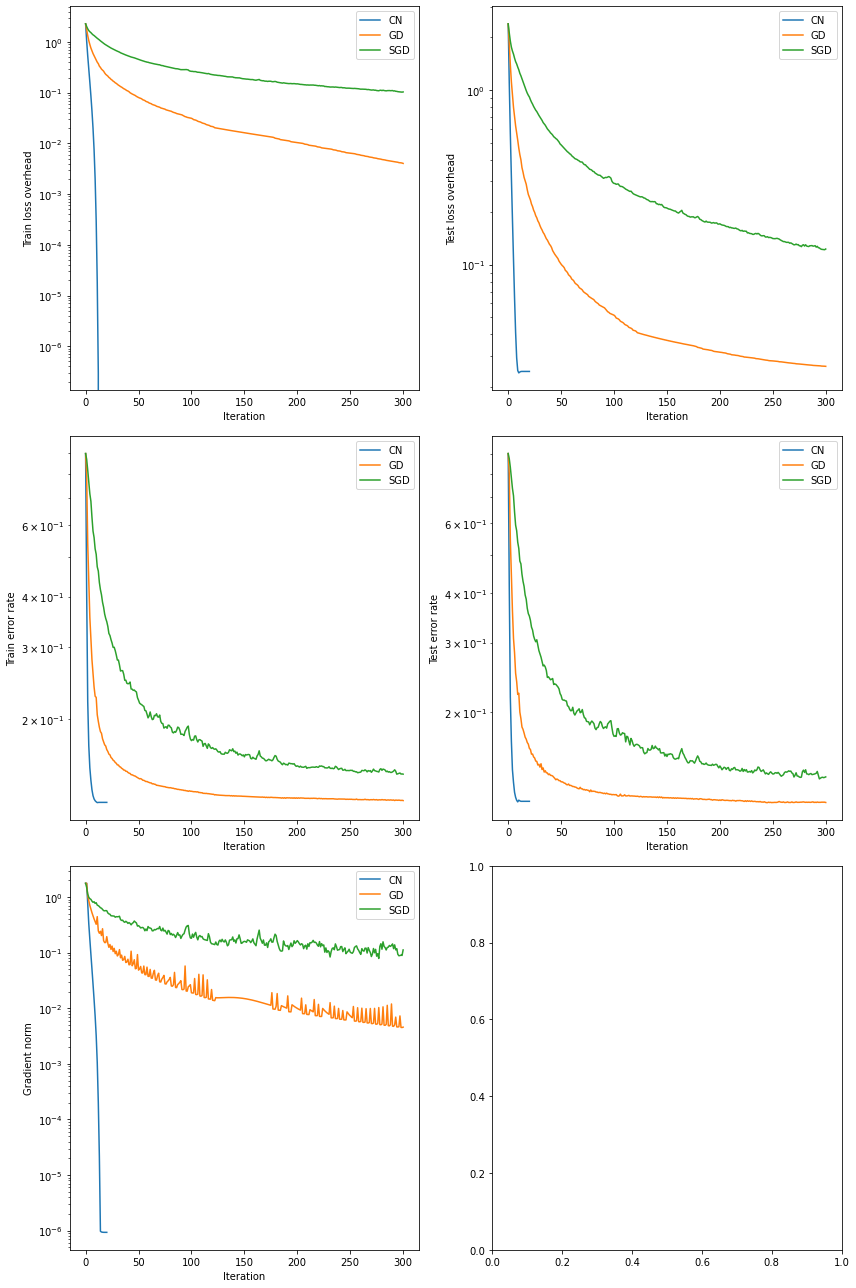

In [11]:
fig, ax = plt.subplots(3,2, figsize=(12,18))

ax[0,0].plot(CN_metrics["iter"], CN_metrics["train_loss"] - MIN_TRAIN_LOSS, label="CN")
ax[0,0].plot(GD_metrics["iter"], GD_metrics["train_loss"] - MIN_TRAIN_LOSS, label="GD")
ax[0,0].plot(SGD_metrics["iter"], SGD_metrics["train_loss"] - MIN_TRAIN_LOSS, label="SGD")
ax[0,0].set_xlabel("Iteration")
ax[0,0].set_ylabel("Train loss overhead")
ax[0,0].set_yscale('log')
ax[0,0].legend()

ax[0,1].plot(CN_metrics["iter"], CN_metrics["test_loss"] - MIN_TEST_LOSS, label="CN")
ax[0,1].plot(GD_metrics["iter"], GD_metrics["test_loss"] - MIN_TEST_LOSS, label="GD")
ax[0,1].plot(SGD_metrics["iter"], SGD_metrics["test_loss"] - MIN_TEST_LOSS, label="SGD")
ax[0,1].set_xlabel("Iteration")
ax[0,1].set_ylabel("Test loss overhead")
ax[0,1].set_yscale('log')
ax[0,1].legend()

ax[1,0].plot(CN_metrics["iter"], 1 - CN_metrics["train_acc"], label="CN")
ax[1,0].plot(GD_metrics["iter"], 1 - GD_metrics["train_acc"], label="GD")
ax[1,0].plot(SGD_metrics["iter"], 1 - SGD_metrics["train_acc"], label="SGD")
ax[1,0].set_xlabel("Iteration")
ax[1,0].set_ylabel("Train error rate")
ax[1,0].set_yscale('log')
ax[1,0].legend()

ax[1,1].plot(CN_metrics["iter"], 1 - CN_metrics["test_acc"], label="CN")
ax[1,1].plot(GD_metrics["iter"], 1 - GD_metrics["test_acc"], label="GD")
ax[1,1].plot(SGD_metrics["iter"], 1 - SGD_metrics["test_acc"], label="SGD")
ax[1,1].set_xlabel("Iteration")
ax[1,1].set_ylabel("Test error rate")
ax[1,1].set_yscale('log')
ax[1,1].legend()

ax[2,0].plot(CN_metrics["iter"], CN_metrics["grad_norm"], label="CN")
ax[2,0].plot(GD_metrics["iter"], GD_metrics["grad_norm"], label="GD")
ax[2,0].plot(SGD_metrics["iter"], SGD_metrics["grad_norm"], label="SGD")
ax[2,0].set_xlabel("Iteration")
ax[2,0].set_ylabel("Gradient norm")
ax[2,0].set_yscale('log')
ax[2,0].legend()

fig.tight_layout()
plt.show()

### 1-hidden layer Neural Network

In [7]:
new_dim = 20 # new feature dimension

loss_function = nn.CrossEntropyLoss()
# initialization better be the same for all methods
net = MLP([new_dim, 10, 2], torch.relu)

In [28]:
# loading the dataset for each method to make sure it the same for all methods
# even if the dataset is corrupted during one of the methods training
# for example, SGD may use reshuffling
mnist_dataset = load_and_transform_mnist(new_dim)
# tranforming labels to binary to reduce model size
mnist_dataset["train_targets"] = transform_labels_to_binary(mnist_dataset["train_targets"])
mnist_dataset["test_targets"] = transform_labels_to_binary(mnist_dataset["test_targets"])

net_SGD = copy.deepcopy(net)
optim = torch.optim.SGD(net_SGD.parameters(), lr=0.1)
max_iters = 500
b_size = 128 # batch_size

SGD_trainer = SGDTrainer(net_SGD, mnist_dataset, loss_function, optim, b_size)
SGD_metrics = dict_lists_to_ndarrays(SGD_trainer.train(max_iters=max_iters, print_every=10, eval_every=1))

     0: train loss =  0.7492601275444031, time =  0.00 sec
    10: train loss =  0.6732279658317566, time =  0.01 sec
    20: train loss =  0.6298082470893860, time =  0.01 sec
    30: train loss =  0.5738131403923035, time =  0.02 sec
    40: train loss =  0.5224398970603943, time =  0.03 sec
    50: train loss =  0.4830896556377411, time =  0.03 sec
    60: train loss =  0.4576889574527740, time =  0.04 sec
    70: train loss =  0.4857688844203949, time =  0.05 sec
    80: train loss =  0.4242697656154633, time =  0.06 sec
    90: train loss =  0.4075243175029755, time =  0.07 sec
   100: train loss =  0.3972160220146179, time =  0.07 sec
   110: train loss =  0.3913642466068268, time =  0.08 sec
   120: train loss =  0.3778432309627533, time =  0.09 sec
   130: train loss =  0.3597072660923004, time =  0.09 sec
   140: train loss =  0.3518198132514954, time =  0.10 sec
   150: train loss =  0.3418133556842804, time =  0.11 sec
   160: train loss =  0.3464789390563965, time =  0.11 s

In [29]:
mnist_dataset = load_and_transform_mnist(new_dim)
# tranforming labels to binary to reduce model size
mnist_dataset["train_targets"] = transform_labels_to_binary(mnist_dataset["train_targets"])
mnist_dataset["test_targets"] = transform_labels_to_binary(mnist_dataset["test_targets"])

net_GD = copy.deepcopy(net)
Lipschitz_const = 1.0
Lipschitz_const_min = 0.001
max_iters = 500

GD_trainer = AdaptiveGDTrainer(net_GD, mnist_dataset, loss_function, Lipschitz_const, Lipschitz_const_min)
GD_metrics = dict_lists_to_ndarrays(GD_trainer.train(max_iters=max_iters, print_every=10, eval_every=1))

     0: train loss =  0.7492601275444031, L =  1.000, time =  0.00 sec
    10: train loss =  0.4600271880626678, L =  8.000, time =  0.24 sec
    20: train loss =  0.4153727293014526, L =  2.000, time =  0.46 sec
    30: train loss =  0.3893067240715027, L =  4.000, time =  0.69 sec
    40: train loss =  0.3667325377464294, L =  8.000, time =  0.93 sec
    50: train loss =  0.3453945517539978, L =  2.000, time =  1.15 sec
    60: train loss =  0.3273071348667145, L =  2.000, time =  1.37 sec
    70: train loss =  0.3138657212257385, L =  16.000, time =  1.62 sec
    80: train loss =  0.3012080788612366, L =  4.000, time =  1.83 sec
    90: train loss =  0.2898810803890228, L =  16.000, time =  2.09 sec
   100: train loss =  0.2813734412193298, L =  4.000, time =  2.36 sec
   110: train loss =  0.2736338675022125, L =  16.000, time =  2.64 sec
   120: train loss =  0.2677659690380096, L =  4.000, time =  2.91 sec
   130: train loss =  0.2616473436355591, L =  8.000, time =  3.20 sec
   

In [37]:
mnist_dataset = load_and_transform_mnist(new_dim)
# tranforming labels to binary to reduce model size
mnist_dataset["train_targets"] = transform_labels_to_binary(mnist_dataset["train_targets"])
mnist_dataset["test_targets"] = transform_labels_to_binary(mnist_dataset["test_targets"])

net_CN = copy.deepcopy(net)
Lipschitz_const = 1.0
Lipschitz_const_min = 0.001
max_iters = 500

CN_trainer = AdaptiveCubicNewtonTrainer(net_CN, mnist_dataset, loss_function, Lipschitz_const, Lipschitz_const_min)
CN_metrics = dict_lists_to_ndarrays(CN_trainer.train(max_iters=max_iters, print_every=10, eval_every=1))

    0: train loss =  0.7492601275444031, M =  1.000, time =  0.00 sec
   10: train loss =  0.4197701215744019, M =  8.000, time =  23.81 sec
   20: train loss =  0.3465965688228607, M =  16.000, time =  50.16 sec
   30: train loss =  0.2928809821605682, M =  8.000, time =  83.22 sec
   40: train loss =  0.2704122364521027, M =  64.000, time =  115.79 sec
   50: train loss =  0.2557404041290283, M =  64.000, time =  148.81 sec
   60: train loss =  0.2452729344367981, M =  256.000, time =  180.85 sec
   70: train loss =  0.2366527020931244, M =  64.000, time =  211.91 sec
   80: train loss =  0.2286886125802994, M =  64.000, time =  244.96 sec
   90: train loss =  0.2233588695526123, M =  256.000, time =  281.87 sec
  100: train loss =  0.2178901880979538, M =  256.000, time =  323.21 sec
  110: train loss =  0.2141493707895279, M =  256.000, time =  352.38 sec
  120: train loss =  0.2111186981201172, M =  128.000, time =  385.91 sec
  130: train loss =  0.2080814391374588, M =  128.000,

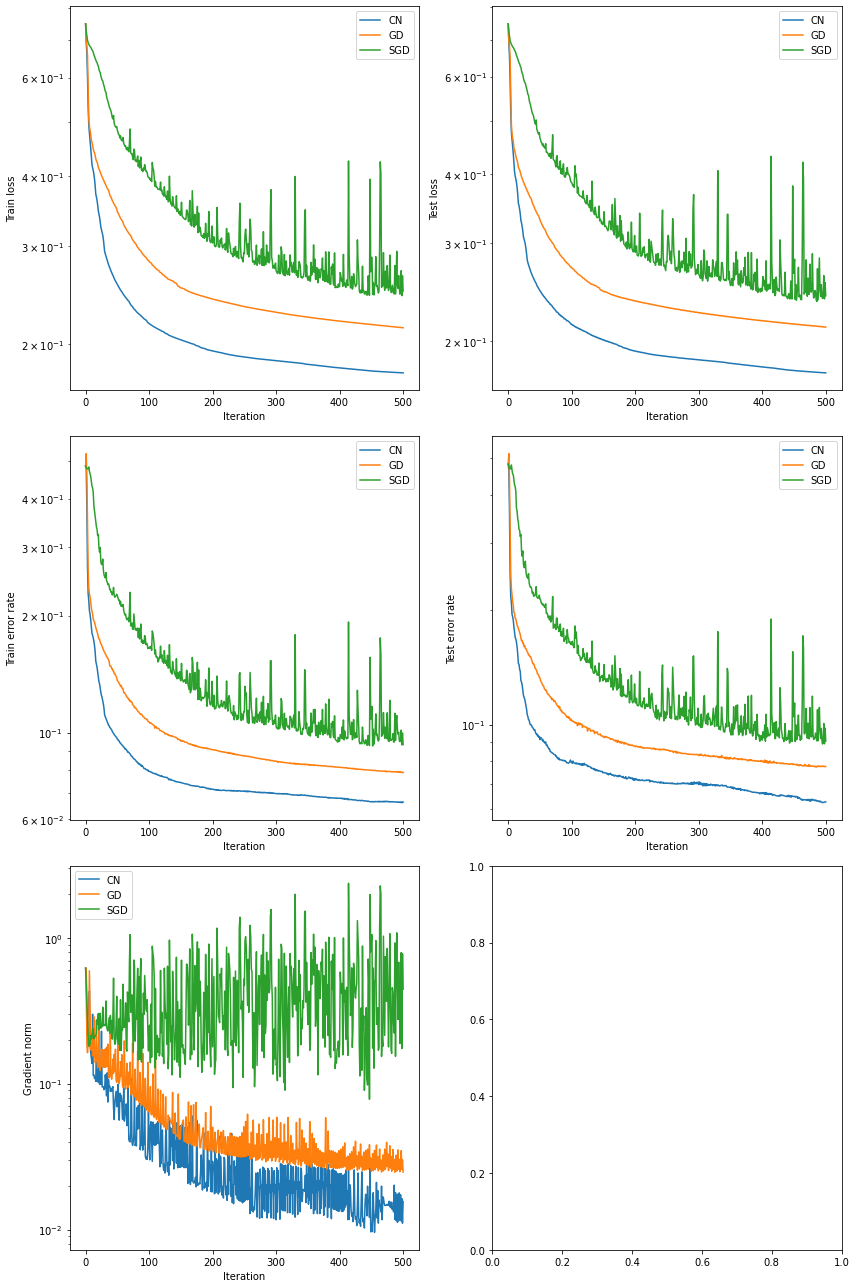

In [38]:
fig, ax = plt.subplots(3,2, figsize=(12,18))

ax[0,0].plot(CN_metrics["iter"], CN_metrics["train_loss"], label="CN")
ax[0,0].plot(GD_metrics["iter"], GD_metrics["train_loss"], label="GD")
ax[0,0].plot(SGD_metrics["iter"], SGD_metrics["train_loss"], label="SGD")
ax[0,0].set_xlabel("Iteration")
ax[0,0].set_ylabel("Train loss")
ax[0,0].set_yscale('log')
ax[0,0].legend()

ax[0,1].plot(CN_metrics["iter"], CN_metrics["test_loss"], label="CN")
ax[0,1].plot(GD_metrics["iter"], GD_metrics["test_loss"], label="GD")
ax[0,1].plot(SGD_metrics["iter"], SGD_metrics["test_loss"], label="SGD")
ax[0,1].set_xlabel("Iteration")
ax[0,1].set_ylabel("Test loss")
ax[0,1].set_yscale('log')
ax[0,1].legend()

ax[1,0].plot(CN_metrics["iter"], 1 - CN_metrics["train_acc"], label="CN")
ax[1,0].plot(GD_metrics["iter"], 1 - GD_metrics["train_acc"], label="GD")
ax[1,0].plot(SGD_metrics["iter"], 1 - SGD_metrics["train_acc"], label="SGD")
ax[1,0].set_xlabel("Iteration")
ax[1,0].set_ylabel("Train error rate")
ax[1,0].set_yscale('log')
ax[1,0].legend()

ax[1,1].plot(CN_metrics["iter"], 1 - CN_metrics["test_acc"], label="CN")
ax[1,1].plot(GD_metrics["iter"], 1 - GD_metrics["test_acc"], label="GD")
ax[1,1].plot(SGD_metrics["iter"], 1 - SGD_metrics["test_acc"], label="SGD")
ax[1,1].set_xlabel("Iteration")
ax[1,1].set_ylabel("Test error rate")
ax[1,1].set_yscale('log')
ax[1,1].legend()

ax[2,0].plot(CN_metrics["iter"], CN_metrics["grad_norm"], label="CN")
ax[2,0].plot(GD_metrics["iter"], GD_metrics["grad_norm"], label="GD")
ax[2,0].plot(SGD_metrics["iter"], SGD_metrics["grad_norm"], label="SGD")
ax[2,0].set_xlabel("Iteration")
ax[2,0].set_ylabel("Gradient norm")
ax[2,0].set_yscale('log')
ax[2,0].legend()

fig.tight_layout()
plt.show()